In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn, optim
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch.nn.functional as func
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [2]:
df = pd.read_csv("weather_corato.csv", index_col="datetime", parse_dates=True)
features_and_target = ["temperature", "relativehumidity", "pressure_msl", "precipitation"]
df = df[features_and_target]

In [3]:
df.describe()

,temperature,relativehumidity,pressure_msl,precipitation
count,65018.000000,65018.000000,65018.000000,65018.000000
mean,16.041801,71.218601,1015.651829,0.073796
std,7.513854,17.651779,6.722342,0.324917
min,-8.100000,10.000000,985.100000,0.000000
25%,10.000000,58.000000,1011.700000,0.000000
50%,15.300000,73.000000,1015.300000,0.000000
75%,21.600000,86.000000,1019.600000,0.000000
max,40.200000,100.000000,1040.400000,13.600000


In [4]:
# fill missing dates (if there are any)
new_date_range = pd.date_range(start="2016-01-01 00:00:00", end="2022-12-31 23:00:00", freq="H")
df = df.reindex(new_date_range, fill_value=np.nan)
df

,temperature,relativehumidity,pressure_msl,precipitation
2016-01-01 00:00:00,3.4,87,1027.2,0.0
2016-01-01 01:00:00,3.1,91,1026.9,0.0
2016-01-01 02:00:00,2.5,94,1026.7,0.0
2016-01-01 03:00:00,1.9,95,1026.8,0.0
2016-01-01 04:00:00,1.7,96,1026.8,0.0
...,...,...,...,...
2022-12-31 19:00:00,12.4,89,1030.8,0.0
2022-12-31 20:00:00,10.6,94,1031.1,0.0
2022-12-31 21:00:00,10.2,91,1031.4,0.0
2022-12-31 22:00:00,8.4,96,1031.5,0.0


In [5]:
df.isnull().sum()

temperature         0
relativehumidity    0
pressure_msl        0
precipitation       0
dtype: int64

In [6]:
df.dtypes

temperature         float64
relativehumidity      int64
pressure_msl        float64
precipitation       float64
dtype: object

In [7]:
df["precipitation"] = df["precipitation"].apply(lambda x: 1 if x > 0 else 0)
df["precipitation"].value_counts()

0    54049
1     7319
Name: precipitation, dtype: int64

In [8]:
df

,temperature,relativehumidity,pressure_msl,precipitation
2016-01-01 00:00:00,3.4,87,1027.2,0
2016-01-01 01:00:00,3.1,91,1026.9,0
2016-01-01 02:00:00,2.5,94,1026.7,0
2016-01-01 03:00:00,1.9,95,1026.8,0
2016-01-01 04:00:00,1.7,96,1026.8,0
...,...,...,...,...
2022-12-31 19:00:00,12.4,89,1030.8,0
2022-12-31 20:00:00,10.6,94,1031.1,0
2022-12-31 21:00:00,10.2,91,1031.4,0
2022-12-31 22:00:00,8.4,96,1031.5,0


In [9]:
features = features_and_target[:-1]
for feat in features:
  df[f"{feat}_diff"] = df[feat].diff(periods=1)

# remove first two records
df = df[1:]

In [10]:
df

,temperature,relativehumidity,pressure_msl,precipitation,temperature_diff,relativehumidity_diff,pressure_msl_diff
2016-01-01 01:00:00,3.1,91,1026.9,0,-0.3,4.0,-0.3
2016-01-01 02:00:00,2.5,94,1026.7,0,-0.6,3.0,-0.2
2016-01-01 03:00:00,1.9,95,1026.8,0,-0.6,1.0,0.1
2016-01-01 04:00:00,1.7,96,1026.8,0,-0.2,1.0,0.0
2016-01-01 05:00:00,1.5,96,1026.7,0,-0.2,0.0,-0.1
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,12.4,89,1030.8,0,-0.3,-1.0,0.2
2022-12-31 20:00:00,10.6,94,1031.1,0,-1.8,5.0,0.3
2022-12-31 21:00:00,10.2,91,1031.4,0,-0.4,-3.0,0.3
2022-12-31 22:00:00,8.4,96,1031.5,0,-1.8,5.0,0.1


In [11]:
df["precipitation_next_hour"] = df["precipitation"].shift(-1)
df = df[:-1]
df["precipitation_next_hour"] = df["precipitation_next_hour"].astype(int)
df.drop(columns=["precipitation"], inplace=True)

<ipython-input-11-bbe19e4c6c49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precipitation_next_hour"] = df["precipitation"].shift(-1)
<ipython-input-11-bbe19e4c6c49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precipitation_next_hour"] = df["precipitation_next_hour"].astype(int)
<ipython-input-11-bbe19e4c6c49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

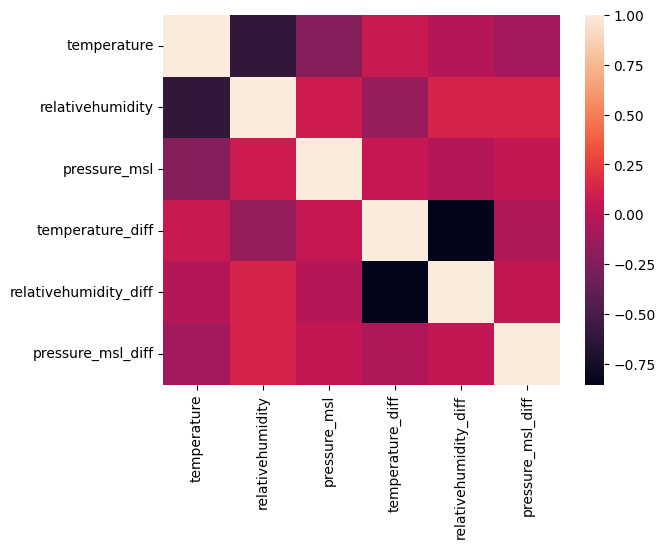

In [12]:
import seaborn as sns
%matplotlib inline

features = df.columns[:-1]

sns.heatmap(df[features].corr())
plt.savefig('correlation.png', dpi=300)

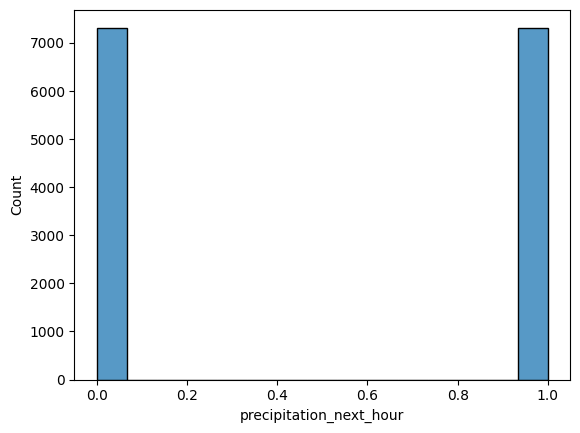

In [13]:
g = df.groupby('precipitation_next_hour')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
sns.histplot(df["precipitation_next_hour"])
plt.savefig("count_target.png", dpi=300)

In [14]:
df["precipitation_next_hour"].value_counts()

0    7319
1    7319
Name: precipitation_next_hour, dtype: int64

In [15]:
X = df[features].values
y = df[["precipitation_next_hour"]].values

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,  shuffle=True, random_state=42)

In [17]:
# Apply normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# save scaler to file
import joblib
joblib.dump(scaler, "./scaler.save")

['./scaler.save']

In [19]:
# Create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, shuffle=True)

# Neural Net

In [20]:
import torch
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).float())

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.squeeze(torch.from_numpy(y_valid).float())

X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).float())

In [21]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([9368, 6]) torch.Size([9368])
torch.Size([2342, 6]) torch.Size([2342])
torch.Size([2928, 6]) torch.Size([2928])


In [22]:
import torch.nn as nn
import torch.nn.functional as func

# Create the model
class Model(nn.Module):
  def __init__(self, n_features):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(n_features, 64)
    self.fc2 = nn.Linear(64, 128)
    self.fc3 = nn.Linear(128, 1)

    #self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = func.relu(self.fc1(x))
    x = func.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [23]:
model = Model(X_train.shape[1])

In [24]:
import torch.optim as optim

# Criterion
criterion = nn.BCELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
model = model.to(device)
criterion = criterion.to(device)

In [27]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=150)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=150)

Epoch 1	Training loss: 0.607331	Valid loss: 0.586380
Validation loss decreased: inf -> 0.586380. Saving model...

Epoch 2	Training loss: 0.574157	Valid loss: 0.574549
Validation loss decreased: 0.586380 -> 0.574549. Saving model...

Epoch 3	Training loss: 0.564429	Valid loss: 0.565401
Validation loss decreased: 0.574549 -> 0.565401. Saving model...

Epoch 4	Training loss: 0.556789	Valid loss: 0.558482
Validation loss decreased: 0.565401 -> 0.558482. Saving model...

Epoch 5	Training loss: 0.550966	Valid loss: 0.553731
Validation loss decreased: 0.558482 -> 0.553731. Saving model...

Epoch 6	Training loss: 0.546774	Valid loss: 0.550410
Validation loss decreased: 0.553731 -> 0.550410. Saving model...

Epoch 7	Training loss: 0.543429	Valid loss: 0.547958
Validation loss decreased: 0.550410 -> 0.547958. Saving model...

Epoch 8	Training loss: 0.540627	Valid loss: 0.546042
Validation loss decreased: 0.547958 -> 0.546042. Saving model...

Epoch 9	Training loss: 0.538143	Valid loss: 0.544315


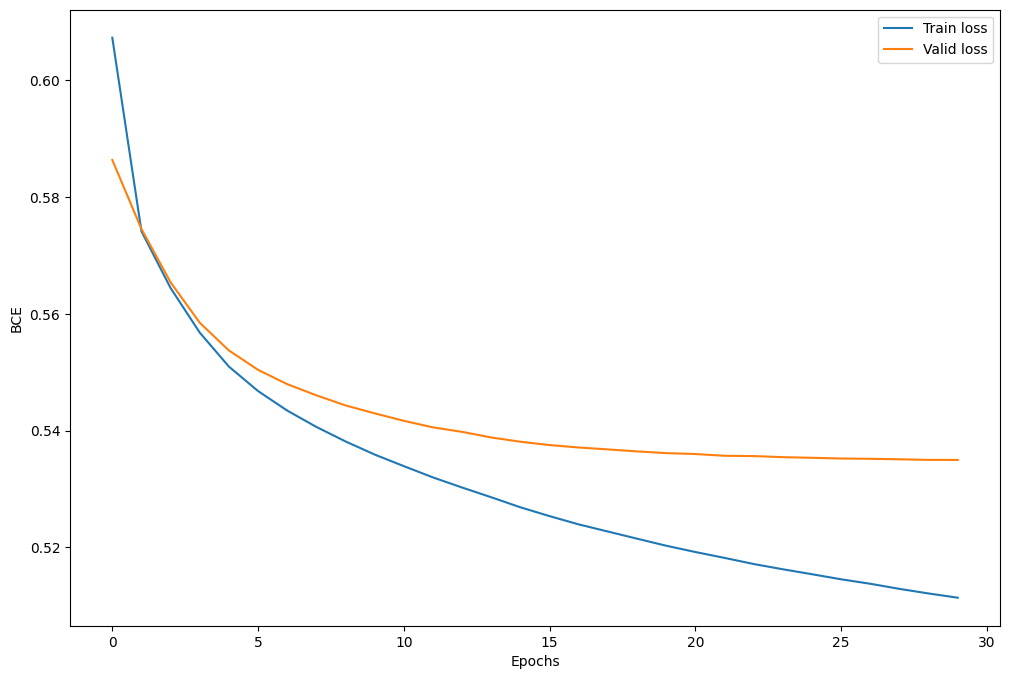

In [28]:
n_epochs = 30
valid_loss_min = np.Inf
best_model_dict = None

train_losses = []
valid_losses = []

for epoch in range(n_epochs):

  train_loss = 0.0
  valid_loss = 0.0

  ###################
  # train the model #
  ###################
  model.train()
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    # 1. clear the gradients
    optimizer.zero_grad()
    # 2. forward pass
    y_pred = model(data)
    # 3. calculate the loss
    y_pred = torch.squeeze(y_pred)
    loss = criterion(y_pred, target)
    # 4. backward pass
    loss.backward()
    # 5. single optimization step
    optimizer.step()
    
    train_loss += loss.item()*data.size(0)

  ######################    
  # validate the model #
  ######################
  model.eval()
  for data, target in valid_loader:
    data, target = data.to(device), target.to(device)
    y_pred = model(data)
    y_pred = torch.squeeze(y_pred)
    loss = criterion(y_pred, target)

    valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  train_losses.append(train_loss)
  valid_loss = valid_loss/len(valid_loader.sampler)
  valid_losses.append(valid_loss)
  print(f"Epoch {epoch+1}\tTraining loss: {train_loss:.6f}\tValid loss: {valid_loss:.6f}")

  if valid_loss <= valid_loss_min:
    print(f"Validation loss decreased: {valid_loss_min:.6f} -> {valid_loss:.6f}. Saving model...\n")
    best_model_dict = model.state_dict()
    valid_loss_min = valid_loss

plt.figure(figsize=(12,8))
plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Valid loss")
plt.xlabel("Epochs")
plt.ylabel("BCE")
plt.legend()
plt.savefig("loss_curves.png", dpi=300)

In [29]:
# save best model
torch.save(best_model_dict, "./model")

In [30]:
# load model with lowest valid loss
model.load_state_dict(torch.load("./model"))

<All keys matched successfully>

In [31]:
model.eval()
model.to('cpu')
y_pred = model(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

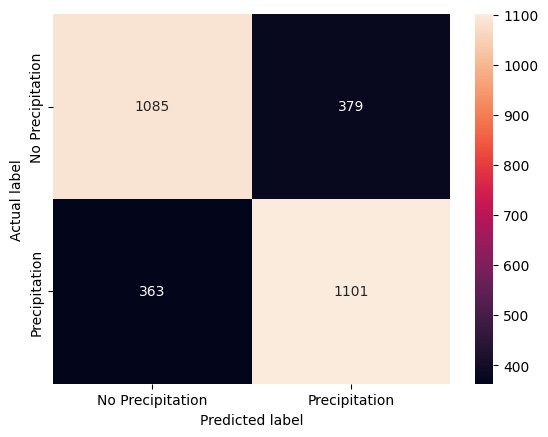

In [32]:
classes = ["No Precipitation", "Precipitation"]
conf_mat = confusion_matrix(y_test, y_pred)
df_conf_mat = pd.DataFrame(conf_mat, index = classes, columns = classes)
heat_map = sns.heatmap(df_conf_mat, annot = True, fmt = "d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.savefig("confusion_matrix.png", dpi=300)

In [34]:
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

No Precipitation       0.75      0.74      0.75      1464
   Precipitation       0.74      0.75      0.75      1464

        accuracy                           0.75      2928
       macro avg       0.75      0.75      0.75      2928
    weighted avg       0.75      0.75      0.75      2928

